In [2]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

load Zebrafish data of thijs

In [3]:
spikes, behavior, coordinates, df, stimulus = load_data()

<AxesSubplot:>

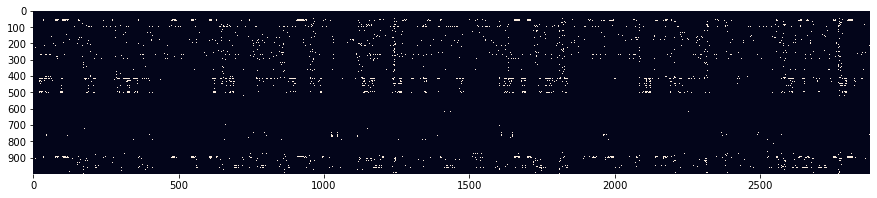

In [4]:
plt.figure(figsize=(15,3))
sns.heatmap(spikes[:1000, :3000] > .15, cbar=False, xticklabels=500, yticklabels=100)

1. take N random neurons
2. put data in batches
3. train RBM and RTRBM with the same learning parameters
4. infer RBM and RTRBM with the same infering parameters
5. calculate the RMSE of all moments and pairwise moments in every epoch
6. repeat 1 - 5 X times
7. compare mean errors and plot against epochs

In [16]:
# run parameters
N_H = 10                  # number of hidden units
n_epochs = 2000           # number of total training epochs
infer_every_x_epochs = 50 # number of training epochs after which we infer the test data
N = 250                   # number of visible neurons
runs = 10                 # number of runs
thresh = .15              # firing threshold

# empty tensors to save errors in
nrmse_rtrbm = torch.zeros(5, n_epochs // infer_every_x_epochs, runs)
nrmse_rbm = torch.zeros(5, n_epochs // infer_every_x_epochs, runs)

for run in range(runs):
    # take N random neurons
    neuron_idx = torch.randint(spikes.shape[0], (N, ))
    data = torch.tensor(spikes[neuron_idx, :] > thresh, dtype=torch.float)

    # put data in train and test batches
    train, test = train_test_split(data)

    # create machines
    rtrbm = RTRBM(train, N_H=N_H, device='cpu')
    rbm = RBM(train, N_H=N_H, device='cpu')

    # learn machines, every x epochs infer test batches
    for i in tqdm(range(n_epochs // infer_every_x_epochs)):

        # train RBM and RTRBM with the same learning parameters
        rtrbm.learn(n_epochs=infer_every_x_epochs, batchsize=80, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0, disable_tqdm=True)
        rbm.learn(n_epochs=infer_every_x_epochs, batchsize=80, CDk=10, PCD=False, lr=1e-4, mom=0, wc=0, disable_tqdm=True)

        # infer RBM and RTRBM with the same infering parameters
        v_est_rtrbm   = torch.zeros_like(test)
        v_est_rbm     = torch.zeros_like(test)
        h_est_rtrbm   = torch.zeros(N_H, test.shape[1], test.shape[2])
        h_est_rbm     = torch.zeros(N_H, test.shape[1], test.shape[2])
        h_test_rtrbm  = torch.zeros(N_H, test.shape[1], test.shape[2])
        h_test_rbm    = torch.zeros(N_H, test.shape[1], test.shape[2])
        h_train_rtrbm = torch.zeros(N_H, train.shape[1], train.shape[2])
        h_train_rbm   = torch.zeros(N_H, train.shape[1], train.shape[2])

        for batch in range(test.shape[2]):
            # estimation (infered) set
            v_est_rtrbm[:, :, batch], h_est_rtrbm[:, :, batch] = rtrbm.sample(test[:, 0, batch].T, mode=1, pre_gibbs_k=0, gibbs_k=1, chain=test.shape[1], disable_tqdm=True)
            v_est_rbm[:, :, batch], h_est_rbm[:, :, batch] = rbm.sample(test[:, 0, batch].T, mode=1, pre_gibbs_k=0, gibbs_k=1, chain=test.shape[1], disable_tqdm=True)

            # test set
            h_test_rtrbm[:, :, batch] = rtrbm.visible_to_expected_hidden(test[:, :, batch])
            h_test_rbm[:, :, batch] = rbm.visible_to_hidden(test[:, :, batch].T)[0].T

        for batch in range(train.shape[2]):
            # train set
            h_train_rtrbm[:, :, batch] = rtrbm.visible_to_expected_hidden(train[:, :, batch])
            h_train_rbm[:, :, batch] = rbm.visible_to_hidden(train[:, :, batch].T)[0].T

        # reshape all tensors from (V, T, n_batches) to (V, T x n_batches)
        v_train = train.detach().clone()
        v_test = test.detach().clone()
        tensors = [v_train, h_train_rtrbm, v_test, h_test_rtrbm, v_est_rtrbm, h_est_rtrbm, h_train_rbm, h_test_rbm, v_est_rbm, h_est_rbm]
        reshaped_tensors = reshape_list_of_tensors(tensors)
        v_train, h_train_rtrbm, v_test, h_test_rtrbm, v_est_rtrbm, h_est_rtrbm, h_train_rbm, h_test_rbm, v_est_rbm, h_est_rbm = reshaped_tensors

        # calculate normalised Root Mean Square Error of all statistics
        nrmse_rtrbm[:, i, run] = torch.tensor(get_nRMSE_moments(rtrbm, v_train, v_test, v_est_rtrbm, h_train_rtrbm, h_test_rtrbm, h_est_rtrbm))
        nrmse_rbm[:, i, run] = torch.tensor(get_nRMSE_moments(rbm, v_train, v_test, v_est_rbm, h_train_rbm, h_test_rbm, h_est_rbm))

100%|███████████████████████████████████████████████████████████████████████████████| 40/40 [1:12:46<00:00, 109.16s/it]


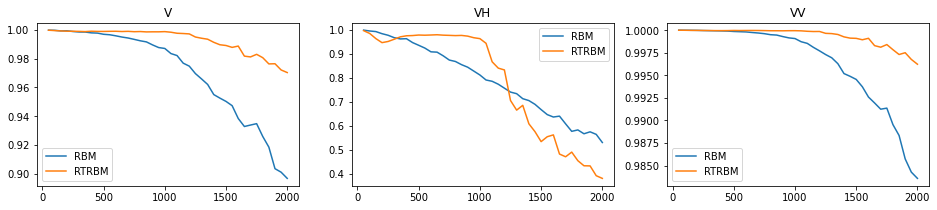

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(16,3))

axes[0].plot(epochs, torch.mean(nrmse_rbm[0, :, :], 1))
axes[0].plot(epochs, torch.mean(nrmse_rtrbm[0, :, :], 1))
axes[0].set_title('V')

axes[1].plot(epochs, torch.mean(nrmse_rbm[2, :, :], 1))
axes[1].plot(epochs, torch.mean(nrmse_rtrbm[2, :, :], 1))
axes[1].set_title('VH')

axes[2].plot(epochs, torch.mean(nrmse_rbm[3, :, :], 1))
axes[2].plot(epochs, torch.mean(nrmse_rtrbm[3, :, :], 1))
axes[2].set_title('VV')

for ax in axes:
    ax.legend(['RBM', 'RTRBM'])